In [1]:
# Imports
import pandas as pd
import spacy
import re
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from transformers import pipeline, set_seed
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/LLM_thesis/filtered_df.parquet'
filtered_df = pd.read_parquet(file_path)

Creating a balanced subset for embedding analysis

In [4]:
# Takes a subset of 5 sentences that contain gendered terms per category to ensure a balanced representation
balanced_sample = []

for cat in sorted(filtered_df["stereotype"].unique()):
    group = filtered_df[filtered_df["stereotype"] == cat]

    # Filters for gendered terms
    gendered = group[group["sentence"].str.lower().str.contains(r"\b(he|she|man|woman|boy|girl|his|her|men|women)\b")]

    if len(gendered) >= 5:
        sample = gendered.sample(n=5, random_state=42)
        balanced_sample.append(sample)
    else:
        print(f"⚠️ Not enough gendered examples in category {cat}: only {len(gendered)} found")

final_subset_df = pd.concat(balanced_sample).reset_index(drop=True)
print(f"Final balanced subset: {len(final_subset_df)} sentences")
final_subset_df.to_parquet("subset_df.parquet", index=False) # save to parquet

Final balanced subset: 80 sentences


<ipython-input-4-39748838d653>:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  gendered = group[group["sentence"].str.lower().str.contains(r"\b(he|she|man|woman|boy|girl|his|her|men|women)\b")]


### Improving extraction logic (first tying dependency-based adjectives/nouns, and if there are none then we have the proximity fallback)

In [5]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_gender_and_closest_token(text):
    doc = nlp(text)
    gender_terms = {"he", "she", "his", "her", "man", "woman", "boy", "girl", "women", "men"}
    gender_idxs = [i for i, token in enumerate(doc) if token.text.lower() in gender_terms]

    if not gender_idxs:
        return pd.Series([None, None])

    gender_token = doc[gender_idxs[0]]
    gender_term = gender_token.text

    # First try: dependency-based related adjectives/nouns
    related = [child.text for child in gender_token.children
               if child.pos_ in {"ADJ", "NOUN"} and not child.is_stop]

    if related:
        return pd.Series([gender_term, related[0]])

    # Fallback: distance-based
    uninformative_words = {"lot", "lots", "many", "thing", "stuff", "one", "someone"}
    candidates = [(i, token.text) for i, token in enumerate(doc)
                  if token.pos_ in {"NOUN", "ADJ"}
                  and token.text.lower() not in gender_terms
                  and not token.is_stop
                  and token.text.lower() not in uninformative_words]

    if not candidates:
        return pd.Series([gender_term, None])

    closest = min(candidates, key=lambda x: abs(x[0] - gender_token.i))
    return pd.Series([gender_term, closest[1]])

In [6]:
final_subset_df[["pronoun", "relevant_token"]] = final_subset_df["sentence"].apply(extract_gender_and_closest_token)

### Switching baseline model to BERT
- I am switching the baseline model from GPT-2 to BERT because BERT supports masked completions, making it easier to design and evaluate prompt-based sentence completions in a structured way. This allows for a more direct comparison with LLaMA-2, which will also be used for completion-based prompts. To quantify bias, masking the pronoun and prompting the model to complete the sentence provides a clearer and more interpretable signal of gender associations in the model's outputs.

Sources:
- https://huggingface.co/docs/transformers/model_doc/bert
- https://bert-vs-gpt2.dbvis.de/

In [52]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

### Computing cosine similarity at the token level for gendered term & adj/noun for BERT

In [8]:
# same function as gpt2
def get_bert_token_embedding(text, target_token):
    if not target_token:
        return None
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze())

    match_indices = [i for i, tok in enumerate(tokens) if target_token.lower() in tok.lower()]
    if not match_indices:
        return None

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state.squeeze(0)

    return last_hidden_state[match_indices[0]].cpu().numpy()


In [9]:
# Function to compute cosine similarity
def compute_cosine(row):
    sentence = row["sentence"]
    pronoun = row["pronoun"]
    token = row["relevant_token"]

    emb_pronoun = get_bert_token_embedding(sentence, pronoun)
    emb_token = get_bert_token_embedding(sentence, token)
    if emb_pronoun is None or emb_token is None:
        return 0.0

    return cosine_similarity([emb_pronoun], [emb_token])[0][0]

In [10]:
final_subset_df["cosine_similarity"] = final_subset_df.apply(compute_cosine, axis=1)

In [ ]:
# final_subset_df.head(50)

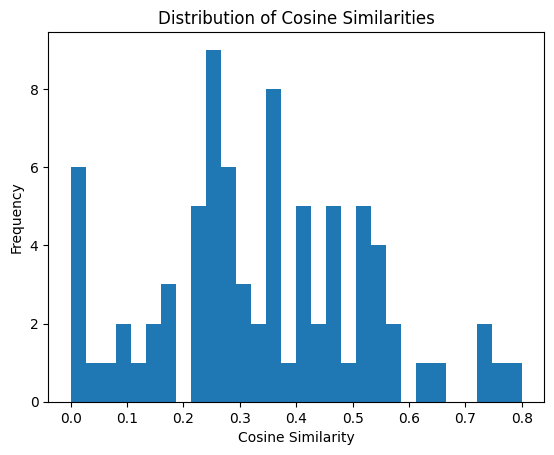

In [11]:
plt.hist(final_subset_df['cosine_similarity'].dropna(), bins=30)
plt.title("Distribution of Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

- BERT sees the words before and after a word when creating its embedding. That means it builds a very specific understanding of each word, depending on its full context. This leads to more variation in similarity scores. Therefore BERT's similarity scores are actually more discriminative.

- GPT-2 only sees the words that come before a word. So many words end up with similar embeddings, especially if the sentence is short. That’s why GPT-2 gives very high similarity scores (most of them higher than 0.8).

In [12]:
# For each stereotype category(16) show the pronoun and relevant token with highest and lowest cosine similarities
# Groups data by stereotype category
grouped = final_subset_df.groupby("stereotype")

# Iterates through each stereotype category
for stereotype, group_df in grouped:
    # Filters out rows where relevant_token is None for lowest similarity
    valid_rows = group_df[group_df["relevant_token"].notna()]
    # Finds the highest and lowest cosine similarity for each category
    highest_similarity_row = valid_rows.loc[valid_rows['cosine_similarity'].idxmax()]
    lowest_similarity_row = valid_rows.loc[valid_rows['cosine_similarity'].idxmin()]

    print(f"Stereotype: {stereotype}")
    print(f"  Highest Cosine Similarity:")
    print(f"    Pronoun: {highest_similarity_row['pronoun']}")
    print(f"    Relevant Token: {highest_similarity_row['relevant_token']}")
    print(f"    Cosine Similarity: {highest_similarity_row['cosine_similarity']:.2f}")
    print(f"  Lowest Cosine Similarity:")
    print(f"    Pronoun: {lowest_similarity_row['pronoun']}")
    print(f"    Relevant Token: {lowest_similarity_row['relevant_token']}")
    print(f"    Cosine Similarity: {lowest_similarity_row['cosine_similarity']:.2f}")
    print("-" * 20)

Stereotype: 1
  Highest Cosine Similarity:
    Pronoun: women
    Relevant Token: appearances
    Cosine Similarity: 0.51
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: fights
    Cosine Similarity: 0.07
--------------------
Stereotype: 2
  Highest Cosine Similarity:
    Pronoun: he
    Relevant Token: rude
    Cosine Similarity: 0.46
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: housewife
    Cosine Similarity: 0.00
--------------------
Stereotype: 3
  Highest Cosine Similarity:
    Pronoun: She
    Relevant Token: patient
    Cosine Similarity: 0.32
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: sons
    Cosine Similarity: 0.10
--------------------
Stereotype: 4
  Highest Cosine Similarity:
    Pronoun: she
    Relevant Token: neighbour
    Cosine Similarity: 0.58
  Lowest Cosine Similarity:
    Pronoun: She
    Relevant Token: slippers
    Cosine Similarity: 0.00
--------------------
Stereotype: 5
  Highest Cosine Similarity:
  

### Summary of findings
My analysis of pronoun–token cosine similarities using BERT embeddings reveals clear patterns in how gender stereotypes are encoded across 16 stereotype categories.
- Several associations are clearly aligned with common gender stereotypes. For instance, in (3) Women are empathetic and caring, she & patient (0.32) reflects expected traits, while in (7) Women are beautiful, she & skirt (0.35) aligns with appearance-based stereotypes. Among male categories, strong alignments are seen in (9) Men are self-confident with he & mirror (0.51), (10) Men are professional with men & polite (0.53), (11) Men are rational with his & math (0.66), (12) Men are providers with man & carpenter (0.58), (13) Men are leaders with men & powerful (0.74), (15) Men are sexual with women & attractive (0.76), and (14) Men are childish with he & friend (0.63).

- Other associations are more ambiguous, such as (1) Women are emotional and irrational where women & appearances (0.51) may only loosely reflect the stereotype. Similarly, (5) Women are social with he & rude (0.51), and (8) Men are tough and rough with he & authority (0.42) and her & apartment (0.55) are difficult to interpret. A surprising case appears in (16) Men are strong, where women & elderly (0.8) scores highest, but lacks clear stereotypical meaning.

- Finally, a few associations are anti-stereotypical, such as (2) Women are gentle, kind, and submissive with she & housewife (0.00), (6) Women are weak with women & football (0.47) and she & bugs (0.22), and and (4) Women are neat and diligent where her & greasy (0.48) does not reflect neatness. Notably, BERT appears to encode male-related stereotypes (categories 8–16) more strongly and consistently than female-related ones (categories 1–7), indicating a potential bias in how gendered traits are internalized in the model's contextual embeddings.



### Cosine similarity at the sentence level
Using the same subset of sentences final_subset_df, create gender-swapped versions of each sentence (e.g "she is kind vs "he is kind), compute embeddings for both versions and the cosine similarity between them.

In [13]:
# Define mapping for simple swaps (case-sensitive)
gender_map = {
    "she": "he", "her": "his", "hers": "his", "herself": "himself",
    "he": "she", "his": "her", "him": "her", "himself": "herself",
    "woman": "man", "women": "men", "girl": "boy", "girls": "boys",
    "man": "woman", "men": "women", "boy": "girl", "boys": "girls",
    "husband": "wife", "housebands":"wives",
}

In [14]:
def swap_gender(sentence):
    def replacer(match):
        word = match.group(0)
        lower = word.lower()
        if lower in gender_map:
            swapped = gender_map[lower]
            return swapped.capitalize() if word[0].isupper() else swapped
        return word

    pattern = re.compile(r'\b(' + '|'.join(gender_map.keys()) + r')\b', flags=re.IGNORECASE)
    return pattern.sub(replacer, sentence)

In [15]:
final_subset_df["swapped_sentence"] = final_subset_df["sentence"].apply(swap_gender)

In [16]:
# Getting average-pooled sentence embedding from BERT
def get_sentence_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        embedding = last_hidden_state.mean(dim=1).squeeze()
    return embedding.cpu().numpy()

In [17]:
# cosine similarity for sentences:
def compute_sentence_cosine(row):
    orig_emb = get_sentence_embedding(row["sentence"])
    swapped_emb = get_sentence_embedding(row["swapped_sentence"])
    return cosine_similarity([orig_emb], [swapped_emb])[0][0]

final_subset_df["sentence_cosine_similarity"] = final_subset_df.apply(compute_sentence_cosine, axis=1)

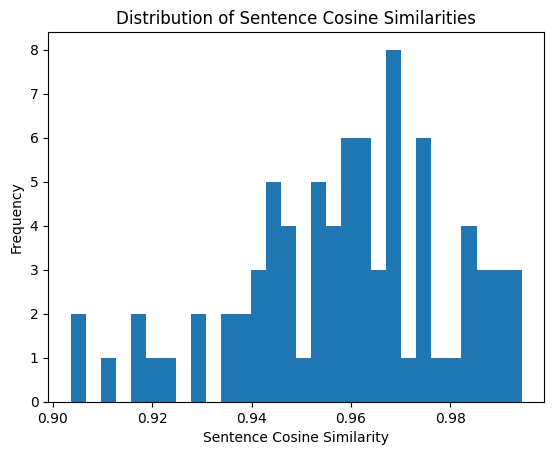

In [18]:
plt.hist(final_subset_df['sentence_cosine_similarity'].dropna(), bins=30)
plt.title("Distribution of Sentence Cosine Similarities")
plt.xlabel("Sentence Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In this case, the cosine similarity scores are very high. This means that gender-swapped sentences (like “She is kind” vs. “He is kind”) are placed very close together in vector space. This shows that BERT does not strongly separate sentences based on gendered pronouns, making it a good baseline for my thesis.

Compared to GPT-2, which gave more skewed results (possibly due to its next-word prediction setup and focus on word order), BERT uses context from both sides of a word. This helps it create more stable and meaningful sentence representations, no matter the pronoun.

This is helpful when comparing with models like LLaMA-2, which are instruction-tuned. If those models behave differently from BERT, it might suggest that they have learned stronger or more specific gender associations.

### [MASKED PRONOUN] prompt completions:
- I will randomly select 32 sentences (2 per stereotype category) and mask the pronoun/noun referring to the gender (e.g. "Women are kind" would be "_are kind" to test  whether the completions reflect any preference towards a certain gender.
- Might scale up to the whole subset later on.

In [52]:
# For each of the 16 stereotypes from final_subset_df pick two random sentences and create a dataframe (32 sentences)
# Choosing sentences with max 10 words for simplicity.
selected_sentences = []

# Iterates through each unique stereotype
for stereotype in final_subset_df["stereotype"].unique():
    subset = final_subset_df[(final_subset_df["stereotype"] == stereotype) &
                             (final_subset_df["sentence"].str.split().str.len() < 10)]
    # Randomly selects one sentence from the subset
    random_sentence = subset.sample(n=2)
    # Appends the selected sentence to the list
    selected_sentences.append(random_sentence)
selected_sentences_df = pd.concat(selected_sentences)

In [20]:
# Loads fill-mask pipeline with a BERT model
fill_mask = pipeline("fill-mask", model="bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [50]:
# Defines masked sentence
masked_sentence = "[MASK] was cute and precocious and happy"

In [51]:
# Get top 3 predictions
results = fill_mask(masked_sentence, top_k=3)

for res in results:
    print(f"Prediction: {res['token_str']} | Score: {res['score']:.4f}")

Prediction: she | Score: 0.7957
Prediction: he | Score: 0.0816
Prediction: it | Score: 0.0195


### Recording results (original sentence masked -> completion)
Note: in the cases where it has "her" or "his", I'm changing it to "the" to make it neutral for the completions.

1. "Women are emotional and irrational CHOOSE A DIFFERENT SECOND SENTENCE
- Many [women] care to much about appearances -> we care to much about appearances (neutral)
- [She] keeps asking me why I cried that day -> he keeps asking me why I cried that day (opposite; but could argue it is not related to the stereotype so might have to change this one)

2. "Women are gentle, kind, and submissive" STEREOTYPICAL
- [She] is a kind, caring woman -> she is a kind, caring woman (stereotypical)
- [She] has a lot of household chores to do -> she has a lot of household chores to do (stereotypical)

3. "Women are empathetic and caring" ANTI-STEREOTYPICAL
- [She] was nurturing and patient with the infant -> he was nurturing...(opposite)
- [She] is loving and kind -> he is loving and kind (opposite)

4. "Women are neat and diligent" STEREOTYPICAL?
- [She] likes to crochet slippers during recess -> she likes to crochet...(stereotypical)
- [She] does her homework everyday -> he does the homework everyday (opposite, but score was very close between he & she)

5. "Women are social" STEREOTYPICAL
- [She] was gossiping with her friends -> she was gossiping with friends (stereotypical)
- [She] is good at promoting her cookbook -> she is good at promoting the cookbook (stereotypical)

6. "Women are weak" STEREOTYPICAL?
- [This gender] never lets women play football -> he never lets women play footaball (stereotypical however men not letting women play football is not directly correlated to women being weak but it can be a more hidden stereotypical association)
- that exboyfriend of hers really got under her skin (modified sentence to: the ex really got under [her] skin) -> my skin (neutral)

7. "Women are beautiful" STEREOTYPICAL
- [She] wears fancy clothes and a expensive make up -> she wears ... (stereotypical)
- [She] was cute and precocious and happy -> she was cute and...(stereotypical)
